# Compare ENSO composites

### MERRA-2 specific humidity-forced SIRS model with HCoV-HKU1 parameters

* Integrated annual infections
* Infection peak amplitude

Last updated August 22 2024

In [17]:
# import packages
from matplotlib import path
import numpy as np
import matplotlib.pyplot as plt

import netCDF4 as nc
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#define figure resolution
plt.rcParams['figure.dpi'] = 250

In [2]:
# specify the time resolution of the MERRA-2 data that was used to force the SIRS model
res = 'weekly' # 'daily'

In [3]:
# import ENSO events (not composites)
# load data
ElNino_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_allevents.nc")
LaNina_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_allevents.nc")
Neutral_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_allevents.nc")

ElNino_1_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_1_allevents.nc")
LaNina_1_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_1_allevents.nc")
Neutral_1_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_1_allevents.nc")

ElNino_2_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_2_allevents.nc")
LaNina_2_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_2_allevents.nc")
Neutral_2_allevents = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_2_allevents.nc")

In [4]:
# absolute values
ElNino = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_composite.nc")
LaNina = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_composite.nc")
neutral = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_composite.nc")

# year after event
ElNino_1 = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_1_composite.nc")
LaNina_1 = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_1_composite.nc")
neutral_1 = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_1_composite.nc")

# 2 years after event
ElNino_2 = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_2_composite.nc")
LaNina_2 = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_2_composite.nc")
neutral_2 = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_2_composite.nc")

In [5]:
HKU1 = xr.open_dataset(f"./data_{res}/HKU1_yearmonth.nc") # monthly mean data

climatology = HKU1.mean('year')

# functions

In [7]:
def get_ttest_mask(da1,da2,thr=0.05,axis=-1,equal_var=False):

    import scipy.stats as scs

    t, p = scs.ttest_ind(da1, da2, axis=axis, equal_var=equal_var)
    
    dims = list(da1.dims[:-1])
    
    ttest = xr.Dataset(
        data_vars=dict(t=(dims, t),
            p=(dims, p),),
        coords={dims[0]: da1[dims[0]],
            dims[1]: da2[dims[1]]},
        attrs=dict(description="2-sided t test results with unequal variances."),)

    # hatching significant values to answer question: are the means different?
    mask = ttest.p.where(ttest.p < thr) 
    print(f'mask computed for p < {thr}.')
    
    return mask, ttest

In [9]:
def get_max_diff_percent(ElNino,LaNina,clim):
    # difference in peak amplitudes -- percent change
    ElNino_max = ElNino.max('month')
    LaNina_max = LaNina.max('month')
    max_diff = ElNino_max - LaNina_max
    
    # divide difference by the climatological peak
    max_diff_percent = max_diff / (clim.max('month')-clim.min('month')) * 100 # percent
    
    return max_diff_percent

In [10]:
def get_sum_diff_percent(ElNino,LaNina,clim):
    # difference in integrated values -- percent change
    ElNino_sum = ElNino.sum('month')
    LaNina_sum = LaNina.sum('month')
    sum_diff = ElNino_sum - LaNina_sum
    
    # divide difference by climatology to get fractional difference (*100 for percent)
    sum_diff_percent = sum_diff / clim.sum('month') * 100
    
    return sum_diff_percent

# Add significance shading

In [11]:
def get_max_diff_percent_CI(ElNino_allevents,LaNina_allevents,clim,varstr):
    # difference in peak amplitudes -- percent change
    ElNino_max = ElNino_allevents[varstr].max('month')
    LaNina_max = LaNina_allevents[varstr].max('month')
    
    max_diff = ElNino_max.mean('year') - LaNina_max.mean('year')
    
    # get mask for 95% CI
    mask, _ = get_ttest_mask(ElNino_max.transpose(...,'year'),
                             LaNina_max.transpose(...,'year'),
                             thr=0.05,axis=-1,equal_var=False)
    
    # divide difference by the climatological peak
    max_diff_percent = max_diff / (clim[varstr].max('month')-clim[varstr].min('month')) * 100 # percent
    
    return max_diff_percent, mask

In [12]:
def get_sum_diff_percent_CI(ElNino_allevents,LaNina_allevents,clim,varstr):
    # input: all events dataset (lat, lon, year, month)
    # climatology: (month, lat, lon)
    # varstr: specifies dataarray
    
    # difference in peak amplitudes -- percent change
    ElNino_sum = ElNino_allevents[varstr].sum('month')
    LaNina_sum = LaNina_allevents[varstr].sum('month')
    
    sum_diff = ElNino_sum.mean('year') - LaNina_sum.mean('year')
    
    # get mask for 95% CI
    mask, _ = get_ttest_mask(ElNino_sum.transpose(...,'year'),
                             LaNina_sum.transpose(...,'year'),
                             thr=0.05,axis=-1,equal_var=False)
    
    # divide difference by climatology to get fractional difference (*100 for percent)
    sum_diff_percent = sum_diff / clim[varstr].sum('month') * 100
    
    return sum_diff_percent, mask

# Plot infected fraction only

In [14]:
def myplot_2(ds,ds2,ds3,
             mask, mask2, mask3,
           levels = np.linspace(-70,70,21),
           suptitle = '', units='units',titles=['ElNino_LaNina','ElNino +1-0', 'LaNina +1-0'],
            textlabel=['a','b','c']):

    fig, axes = plt.subplots(3,1,figsize=(6,7),subplot_kw={'projection': ccrs.Robinson()},
                            constrained_layout=True)

    IT = ds.plot.contourf(ax=axes[0],transform=ccrs.PlateCarree(),add_colorbar=False,extend='both',
                    levels=levels)
    IT2 = ds2.plot.contourf(ax=axes[1],transform=ccrs.PlateCarree(),add_colorbar=False,extend='both',
                    levels=levels)
    IT3 = ds3.plot.contourf(ax=axes[2],transform=ccrs.PlateCarree(),add_colorbar=False,extend='both',
                    levels=levels)
    ##### PLOT MASKS ######
    cs = mask.plot.contourf(ax=axes[0],transform=ccrs.PlateCarree(),levels=[0,0.05],
                       colors='none', hatches=['.....',''],add_colorbar=False)
    # For each level, we set the color of its hatch 
    for collection in cs.collections:
        collection.set_linewidth(0.)
        collection.set_edgecolor('gray')
    cs = mask2.plot.contourf(ax=axes[1],transform=ccrs.PlateCarree(),levels=[0,0.05],
                        colors='none', hatches=['.....',''],add_colorbar=False)
    # For each level, we set the color of its hatch 
    for collection in cs.collections:
        collection.set_linewidth(0.)
        collection.set_edgecolor('gray')
    cs = mask3.plot.contourf(ax=axes[2],transform=ccrs.PlateCarree(),levels=[0,0.05],
                        colors='none', hatches=['.....',''],add_colorbar=False)
    # For each level, we set the color of its hatch 
    for collection in cs.collections:
        collection.set_linewidth(0.)
        collection.set_edgecolor('gray')

    axes[0].set_title(titles[0])
    axes[1].set_title(titles[1])
    axes[2].set_title(titles[2])
    
    axes[0].text(0, 1.1, textlabel[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top')
    axes[1].text(0, 1.1, textlabel[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold', va='top')
    axes[2].text(0, 1.1, textlabel[2], transform=axes[2].transAxes, fontsize=12, fontweight='bold', va='top')

    import cartopy.feature as cfeature
    for ax in axes:
        ax.coastlines(linewidth=0.5,zorder=2)
        ax.add_feature(cfeature.OCEAN, facecolor='white',zorder=1) # edit March 21 2024
        #gl = ax.gridlines(draw_labels=False,linestyle='--')
#         gl.top_labels = False
#         gl.right_labels = False
    
    cbar = fig.colorbar(IT, ax=axes[:], shrink=0.7)
    cbar.set_label(units)

    fig.suptitle(suptitle)
    plt.show()

In [15]:
def IF_plots(clim,
             ElNino,LaNina,
             ElNino_1,LaNina_1,
           levels1 = np.linspace(-70,70,21),
             levels2 = np.linspace(-30,30,21),
            varstr='IT', 
            titles = ['El Niño - La Niña','El Niño yr+1 - yr0','La Niña yr+1 - yr0']):
    
    units = 'Difference [%]'
    
    suptitle = 'Peak difference as percent of\nclimatological seasonal variation'
    ####### El Nino vs. La Nina #######
    max_diff_percent, mask = get_max_diff_percent_CI(ElNino,LaNina,clim,varstr)
    ####### El Nino year 1 vs. year 0 #######
    max_diff_percent_ElNino, mask2 = get_max_diff_percent_CI(ElNino_1,ElNino,clim,varstr)
    ####### La Nina year 1 vs. year 0 #######
    max_diff_percent_LaNina, mask3 = get_max_diff_percent_CI(LaNina_1,LaNina,clim,varstr)
    
    myplot_2(max_diff_percent,max_diff_percent_ElNino,max_diff_percent_LaNina,
             mask, mask2, mask3,
            levels1, suptitle, units, titles, textlabel=['a','b','c'])
    
    suptitle = 'Annual sum difference as percent of\nclimatological annual sum'
    sum_diff_percent, mask = get_sum_diff_percent_CI(ElNino,LaNina,clim,varstr)
    sum_diff_percent_ElNino, mask2 = get_sum_diff_percent_CI(ElNino_1,ElNino,clim,varstr)
    sum_diff_percent_LaNina, mask3 = get_sum_diff_percent_CI(LaNina_1,LaNina,clim,varstr)
    
    myplot_2(sum_diff_percent,sum_diff_percent_ElNino,sum_diff_percent_LaNina,
             mask, mask2, mask3,
             levels2, suptitle, units, titles, textlabel=['d','e','f'])

mask computed for p < 0.05.
mask computed for p < 0.05.
mask computed for p < 0.05.


/tmp/ipykernel_254498/2355691828.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:
/tmp/ipykernel_254498/2355691828.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:
/tmp/ipykernel_254498/2355691828.py:32: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:


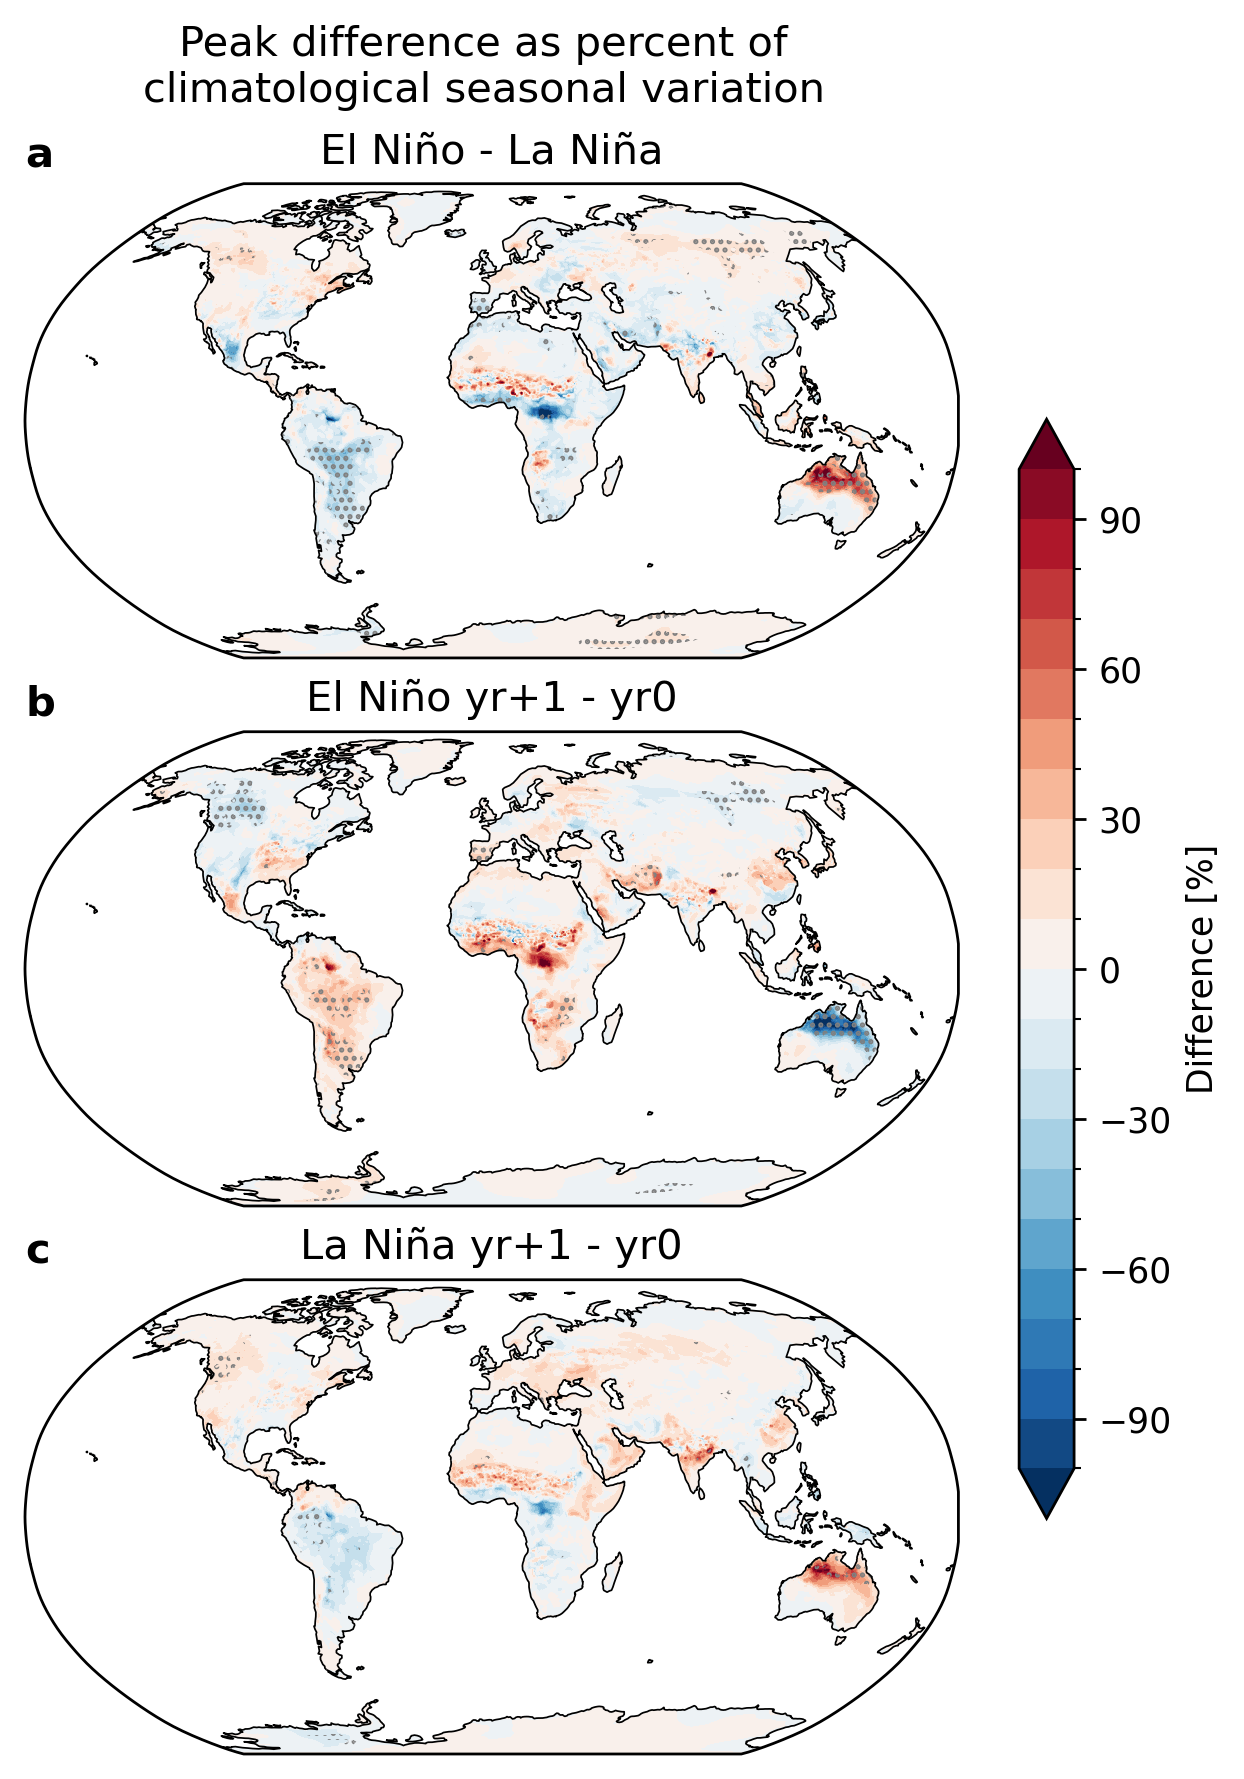

mask computed for p < 0.05.
mask computed for p < 0.05.
mask computed for p < 0.05.


/tmp/ipykernel_254498/2355691828.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:
/tmp/ipykernel_254498/2355691828.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:
/tmp/ipykernel_254498/2355691828.py:32: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:


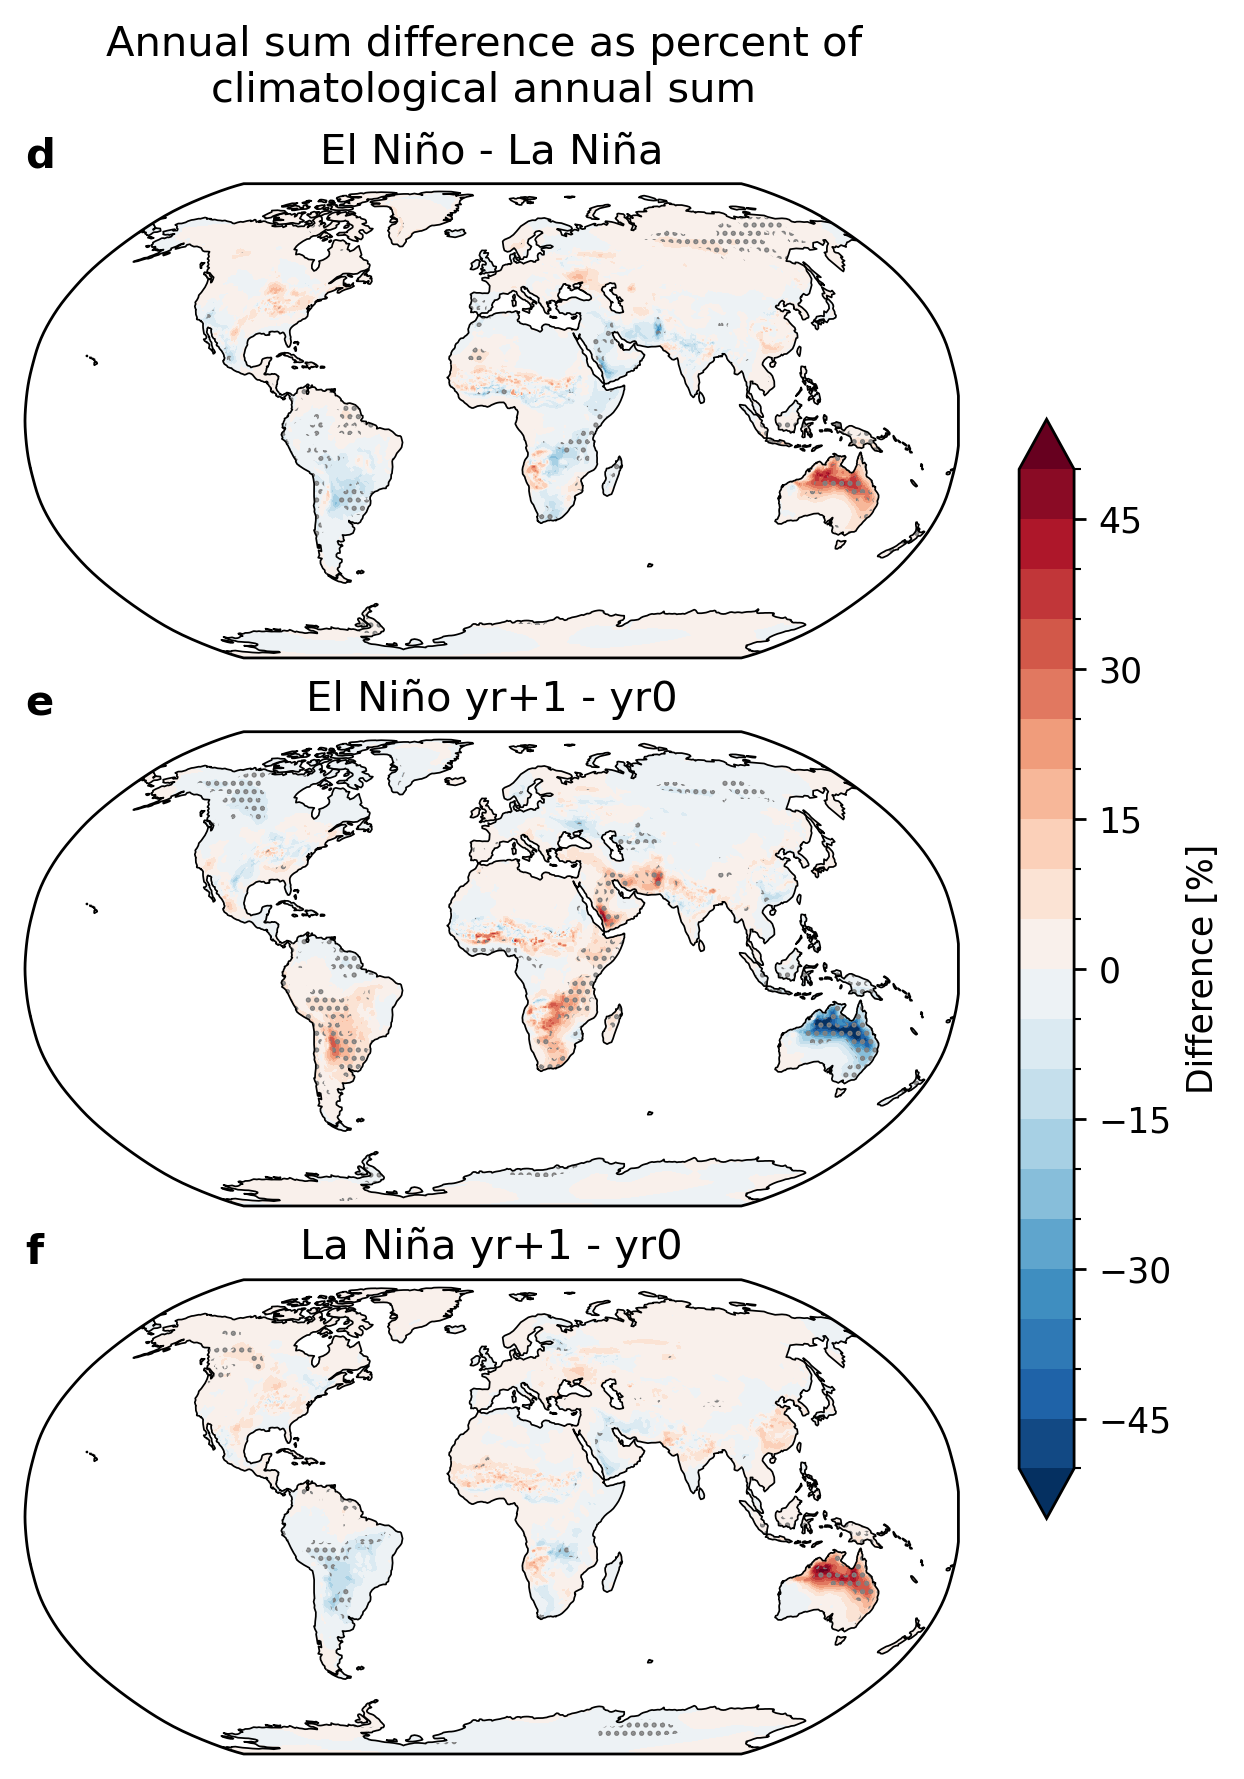

In [18]:
# 38s
IF_plots(climatology,ElNino_allevents,LaNina_allevents,
         ElNino_1_allevents,LaNina_1_allevents,
           levels1 = np.linspace(-100,100,21),
             levels2 = np.linspace(-50,50,21))

# Try: ENSO event year 2 compared to year 1

In [19]:
def myplot_2sp(ds,ds2,
             mask, mask2, 
           levels = np.linspace(-70,70,21),
           suptitle = '', units='units',titles=['ElNino_LaNina','ElNino +1-0', 'LaNina +1-0'],
            textlabel=['a','b','c']):

    fig, axes = plt.subplots(2,1,figsize=(4,4),subplot_kw={'projection': ccrs.Robinson()},
                            constrained_layout=True)

    IT = ds.plot.contourf(ax=axes[0],transform=ccrs.PlateCarree(),add_colorbar=False,extend='both',
                    levels=levels)
    IT2 = ds2.plot.contourf(ax=axes[1],transform=ccrs.PlateCarree(),add_colorbar=False,extend='both',
                    levels=levels)
    ##### PLOT MASKS ######
    cs = mask.plot.contourf(ax=axes[0],transform=ccrs.PlateCarree(),levels=[0,0.05],
                       colors='none', hatches=['.....',''],add_colorbar=False)
    # For each level, we set the color of its hatch 
    for collection in cs.collections:
        collection.set_linewidth(0.)
        collection.set_edgecolor('gray')
    
    cs = mask2.plot.contourf(ax=axes[1],transform=ccrs.PlateCarree(),levels=[0,0.05],
                        colors='none', hatches=['.....',''],add_colorbar=False)
    # For each level, we set the color of its hatch 
    for collection in cs.collections:
        collection.set_linewidth(0.)
        collection.set_edgecolor('gray')
    
    axes[0].set_title(titles[0])
    axes[1].set_title(titles[1])
    
    axes[0].text(0, 1.1, textlabel[0], transform=axes[0].transAxes, fontsize=12, fontweight='bold', va='top')
    axes[1].text(0, 1.1, textlabel[1], transform=axes[1].transAxes, fontsize=12, fontweight='bold', va='top')
    
    import cartopy.feature as cfeature
    for ax in axes:
        ax.set_global()
        ax.coastlines(linewidth=0.5,zorder=2)
        ax.add_feature(cfeature.OCEAN, facecolor='white',zorder=1) # edit March 21 2024
        #gl = ax.gridlines(draw_labels=False,linestyle='--')
#         gl.top_labels = False
#         gl.right_labels = False
    
    cbar = fig.colorbar(IT, ax=axes[:], shrink=0.7)
    cbar.set_label(units)

    fig.suptitle(suptitle)
    plt.show()

In [20]:
def IF_plots_2(clim,
               ElNino,LaNina,
               ElNino_1,LaNina_1,
           levels1 = np.linspace(-60,60,21),
             levels2 = np.linspace(-25,25,21),
            varstr='IT', 
            titles = ['El Niño yr+1 - yr0','La Niña yr+1 - yr0']):
    
    units = 'Difference [%]'
    
    suptitle = 'Peak difference as percent of\nclimatological seasonal variation'
#     ####### El Nino vs. La Nina #######
#     max_diff_percent, mask = get_max_diff_percent_CI(ElNino,LaNina,clim,varstr)
     ####### El Nino year 1 vs. year 0 #######
    max_diff_percent_ElNino, mask2 = get_max_diff_percent_CI(ElNino_1,ElNino,clim,varstr)
    ####### La Nina year 1 vs. year 0 #######
    max_diff_percent_LaNina, mask3 = get_max_diff_percent_CI(LaNina_1,LaNina,clim,varstr)
    
    myplot_2sp(max_diff_percent_ElNino,max_diff_percent_LaNina,
             mask2, mask3, 
            levels1, suptitle, units, titles, textlabel=['a','b'])
    
    suptitle = 'Annual sum difference as percent of\nclimatological annual sum'
    #sum_diff_percent, mask = get_sum_diff_percent_CI(ElNino,LaNina,clim,varstr)
    sum_diff_percent_ElNino, mask2 = get_sum_diff_percent_CI(ElNino_1,ElNino,clim,varstr)
    sum_diff_percent_LaNina, mask3 = get_sum_diff_percent_CI(LaNina_1,LaNina,clim,varstr)
    
    myplot_2sp(sum_diff_percent_ElNino,sum_diff_percent_LaNina,
             mask2, mask3, 
             levels2, suptitle, units, titles, textlabel=['c','d'])

mask computed for p < 0.05.
mask computed for p < 0.05.


/tmp/ipykernel_254498/3899860282.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:
/tmp/ipykernel_254498/3899860282.py:25: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:


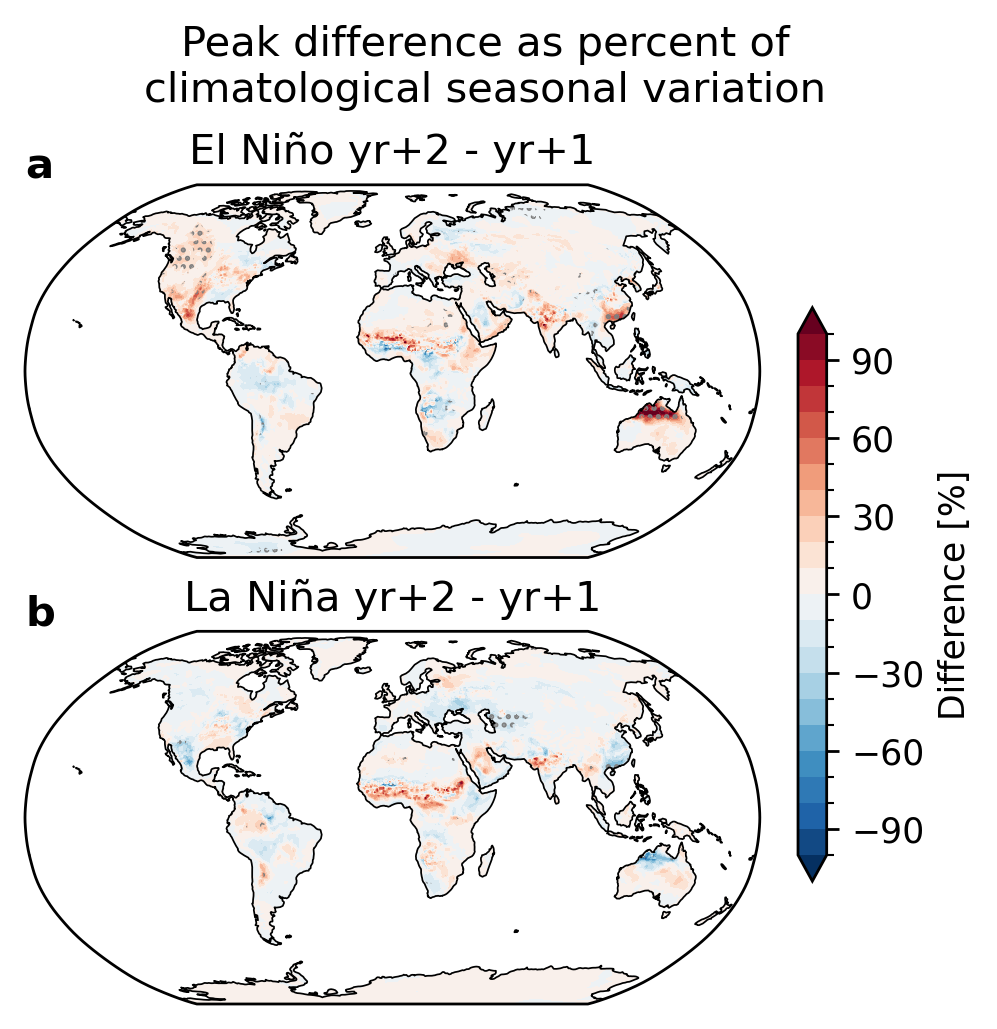

mask computed for p < 0.05.
mask computed for p < 0.05.


/tmp/ipykernel_254498/3899860282.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:
/tmp/ipykernel_254498/3899860282.py:25: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in cs.collections:


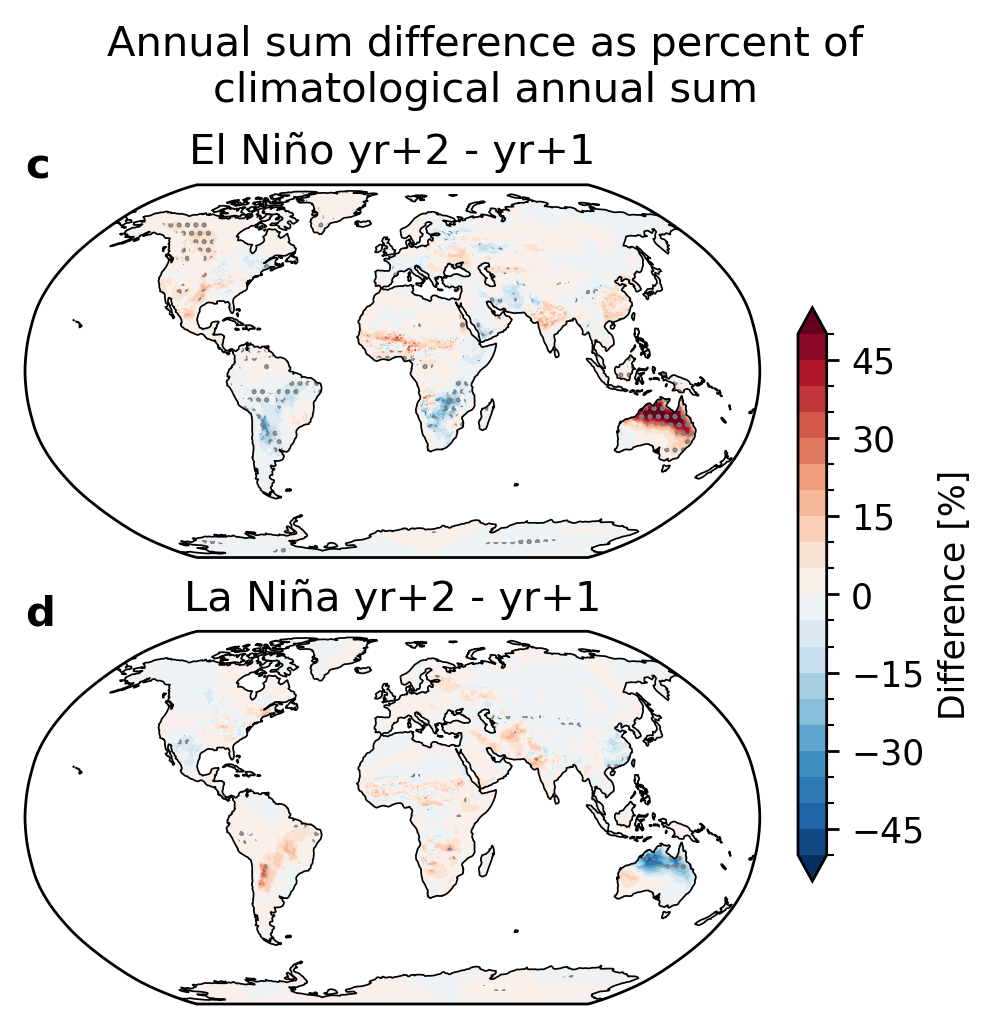

In [22]:
# version with yr 2 vs yr 1
IF_plots_2(climatology,
           ElNino_1_allevents,LaNina_1_allevents,
         ElNino_2_allevents,LaNina_2_allevents,
           levels1 = np.linspace(-100,100,21),
             levels2 = np.linspace(-50,50,21),
        titles=['El Niño yr+2 - yr+1','La Niña yr+2 - yr+1'])